<a href="https://colab.research.google.com/github/nojramu/ALS_Thesis/blob/main/ALS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adaptive Learning System
Made by: Engr. Marjon D. Umbay  
Created for paper article in compliance of the subject of:  
* Numerical Methods and Techniques  
* Technopreneurship and Innovation

## Random Forest Regression and Classification

This section focuses on using Random Forest models to predict two key aspects of the adaptive learning system: cognitive load and engagement level.

*   **Random Forest Regressor**: A machine learning model used here to predict a continuous value, specifically the estimated cognitive load of the learner.
*   **Random Forest Classifier**: A machine learning model used to predict a categorical value, in this case, the learner's engagement level (discretized into different levels).

The process involves loading and preprocessing data, splitting it for training and testing, training the two Random Forest models independently, and then evaluating their performance. The trained models are intended to be used later in the system to provide inputs for the decision-making process.

### Preprosessor of Data

In [62]:
import pandas as pd

def load_and_preprocess_data(csv_file_path=None, data=None):
    """
    Loads data from a CSV file or accepts a DataFrame and performs preprocessing,
    including initial cleaning.

    Args:
      csv_file_path (str, optional): The path to the CSV file containing the data.
                                     If None, 'data' must be provided.
      data (pd.DataFrame, optional): A DataFrame containing the data.
                                   If None, 'csv_file_path' must be provided.

    Returns:
      Cleaned and preprocessed pandas DataFrame, or None if an error occurs,
      required columns are missing, or both csv_file_path and data are None.
    """
    df = None
    if csv_file_path:
        # Load the data from CSV
        try:
            df = pd.read_csv(csv_file_path)
        except FileNotFoundError:
            print(f"Error: File not found at {csv_file_path}")
            return None
        except Exception as e:
            print(f"Error loading CSV file: {e}")
            return None
    elif data is not None:
        # Use the provided DataFrame
        df = data.copy() # Work on a copy to avoid modifying the original
    else:
        print("Error: Either csv_file_path or data must be provided.")
        return None


    if df is None:
        return None

    # Check if required columns exist
    required_features = ['engagement_rate', 'time_on_task_s', 'hint_ratio', 'interaction_count',
                         'task_completed', 'quiz_score', 'difficulty', 'error_rate',
                         'task_timed_out', 'time_before_hint_used']

    # If it's training data, also check for target columns
    is_training_data = 'engagement_level' in df.columns and 'cognitive_load' in df.columns
    if is_training_data:
         required_cols = required_features + ['engagement_level', 'cognitive_load']
    else:
         required_cols = required_features # Only features are required for new data


    if not all(col in df.columns for col in required_cols):
        missing_cols = [col for col in required_cols if col not in df.columns]
        print(f"Error: Missing required columns in the data: {missing_cols}")
        return None

    # Preprocess the data: Convert to numeric and fill missing values
    # Apply to columns expected to be numeric
    numeric_cols_to_fill = [
        'engagement_rate', 'time_on_task_s', 'hint_ratio', 'interaction_count',
        'quiz_score', 'difficulty', 'error_rate', 'time_before_hint_used'
    ]
    if is_training_data:
        numeric_cols_to_fill.append('cognitive_load') # Include cognitive_load for training data


    for col in numeric_cols_to_fill:
         if col in df.columns: # Check if column exists before processing
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(df[col].median()) # Use median for robustness

    # Convert boolean/integer columns to integer (if they exist and are not already numeric)
    int_cols = ['task_completed', 'task_timed_out']
    if is_training_data:
        int_cols.append('engagement_level') # Include engagement_level for training data

    for col in int_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            if col in ['task_completed', 'task_timed_out']:
                 df[col] = df[col].fillna(0).astype(int)
            elif col == 'engagement_level':
                 df[col] = df[col].fillna(df[col].median()).astype(int)

    return df

### Random Forest Training

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np

def train_cognitive_and_engagement_models(csv_file_path, test_set_size=0.2, random_state_value=20, n_estimators_value=100):
  """
  Trains Random Forest models for predicting cognitive load and engagement level
  from a CSV file.

  Args:
    csv_file_path (str): The path to the CSV file containing the data.
    test_set_size (float, optional): The proportion of the dataset to include in the test split. Defaults to 0.2.
    random_state_value (int, optional): Controls the shuffling applied to the data before applying the split.
    n_estimators_value (int, optional): The number of trees in the forest.

  Returns:
    tuple: A tuple containing two trained models:
           - rf_cognitive_load (RandomForestRegressor): Trained model for predicting cognitive load.
           - rf_engagement_level (RandomForestClassifier): Trained model for predicting engagement level.
           Returns (None, None) if data loading or preprocessing fails.
    dict: A dictionary containing the feature names used for training.
  """

  # Load and preprocess the data using the unified function
  df_processed = load_and_preprocess_data(csv_file_path=csv_file_path)

  if df_processed is None:
      return None, None, None # Return None for models and features

  # Define features (X) and targets (y) - 'difficulty' is now a numeric feature
  target_cols = ['cognitive_load', 'engagement_level']
  # Ensure 'difficulty' is included in features if it exists after processing
  features = [col for col in df_processed.columns if col not in target_cols]

  # Ensure all feature columns exist after preprocessing
  # Note: This check is redundant if load_and_preprocess_data already checked required_features
  # but keeping for safety after feature definition.
  if not all(col in df_processed.columns for col in features):
       missing_features = [col for col in features if col not in df_processed.columns]
       print(f"Error: Defined features are missing after preprocessing: {missing_features}")
       return None, None, None


  X = df_processed[features]
  y_cognitive_load = df_processed['cognitive_load']
  y_engagement_level = df_processed['engagement_level']

  # Split data into training and testing sets (optional but good practice)
  # Keeping the original structure for now to match the existing code's apparent intention.
  X_train, X_test, y_cognitive_load_train, y_cognitive_load_test = train_test_split(
      X, y_cognitive_load, test_size=test_set_size, random_state=random_state_value)
  # Split for engagement level - ensure stratification if it's a classification problem and classes are imbalanced
  X_train, X_test, y_engagement_level_train, y_engagement_level_test = train_test_split(
      X, y_engagement_level, test_size=test_set_size, random_state=random_state_value, stratify=y_engagement_level)


  # Initialize and train the Random Forest Regressor for cognitive load
  rf_cognitive_load = RandomForestRegressor(n_estimators=n_estimators_value, random_state=random_state_value)
  rf_cognitive_load.fit(X, y_cognitive_load) # Using all data for training

  # Initialize and train the Random Forest Classifier for engagement level
  rf_engagement_level = RandomForestClassifier(n_estimators=n_estimators_value, random_state=random_state_value)
  rf_engagement_level.fit(X, y_engagement_level) # Using all data for training


  # Evaluate the models on the test set
  cognitive_load_predictions = rf_cognitive_load.predict(X_test)
  print(f"Cognitive Load MSE: {mean_squared_error(y_cognitive_load_test, cognitive_load_predictions)}")

  engagement_level_predictions = rf_engagement_level.predict(X_test)
  print(f"Engagement Level Accuracy: {accuracy_score(y_engagement_level_test, engagement_level_predictions)}")


  # Return trained models and the list of features used for training
  return rf_cognitive_load, rf_engagement_level, features

### Sample Tester

In [64]:
csv_file_path = '/content/drive/MyDrive/The Paper/Numerical/Code/training_data_v2.csv'
train_cognitive_and_engagement_models(csv_file_path, 0.2, 20, 100)

Cognitive Load MSE: 241.2075066445227
Engagement Level Accuracy: 1.0


(RandomForestRegressor(random_state=20),
 RandomForestClassifier(random_state=20),
 ['engagement_rate',
  'time_on_task_s',
  'hint_ratio',
  'interaction_count',
  'task_completed',
  'quiz_score',
  'difficulty',
  'error_rate',
  'task_timed_out',
  'time_before_hint_used'])

### Random Forest Predictor

In [65]:
import pandas as pd
import numpy as np

def predict_cognitive_load_and_engagement(models, feature_names, new_data_path=None, new_data_df=None, new_data_list=None):
  """
  Makes predictions for cognitive load and engagement level using trained models.

  Args:
    models (tuple): A tuple containing the trained cognitive load regressor
                    and engagement level classifier (returned by train_cognitive_and_engagement_models).
    feature_names (list): A list of the feature names the models were trained on.
                          This is returned by train_cognitive_and_engagement_models.
    new_data_path (str, optional): The path to a CSV file containing the new data for prediction.
                                   Either new_data_path, new_data_df, or new_data_list must be provided.
    new_data_df (pd.DataFrame, optional): A DataFrame containing the new data for prediction.
                                        Either new_data_path, new_data_df, or new_data_list must be provided.
    new_data_list (list, optional): A list of values representing a single data point for prediction.
                                    The order of values should match the training features.
                                    Either new_data_path, new_data_df, or new_data_list must be provided.

  Returns:
    tuple: A tuple containing:
           - predicted_cognitive_load (np.array): Predicted cognitive load values.
           - predicted_engagement_level (np.array): Predicted engagement level values.
           Returns (None, None) if models are not provided or data is invalid.
  """
  if models is None or len(models) != 2 or feature_names is None:
    print("Error: Invalid models or feature names provided.")
    return None, None

  if new_data_path is None and new_data_df is None and new_data_list is None:
      print("Error: Either new_data_path, new_data_df, or new_data_list must be provided.")
      return None, None

  rf_cognitive_load, rf_engagement_level = models
  train_features = feature_names # Use feature_names passed from training

  if new_data_list is not None:
      if len(new_data_list) != len(train_features):
          print(f"Error: The number of values in new_data_list ({len(new_data_list)}) does not match the number of training features ({len(train_features)}).")
          return None, None
      # Create a DataFrame from the list, using the training feature names as columns
      # Ensure correct data types here if possible, though load_and_preprocess_data handles conversion
      new_data_for_pred = pd.DataFrame([new_data_list], columns=train_features)

  elif new_data_path is not None:
      # Use the unified load_and_preprocess_data function
      new_data_for_pred = load_and_preprocess_data(csv_file_path=new_data_path)
      if new_data_for_pred is None:
           print(f"Error loading or preprocessing data from {new_data_path}")
           return None, None

  elif new_data_df is not None:
      new_data_for_pred = new_data_df.copy() # Work on a copy

  else:
      return None, None # Should not happen based on checks above


  # Ensure new_data_for_pred has the same columns as the training data
  # Add missing columns from training data with a value of 0
  for col in train_features:
      if col not in new_data_for_pred.columns:
          new_data_for_pred[col] = 0

  # Ensure columns are in the same order as the training data
  # This is crucial for consistent predictions
  try:
      new_data_for_pred = new_data_for_pred[train_features]
  except KeyError as e:
      print(f"Error: Feature '{e}' from training data not found in preprocessed new data.")
      # This might happen if a required original column was missing in the new_data input
      return None, None


  try:
      predicted_cognitive_load = rf_cognitive_load.predict(new_data_for_pred)
      predicted_engagement_level = rf_engagement_level.predict(new_data_for_pred)
      return predicted_cognitive_load, predicted_engagement_level
  except Exception as e:
      print(f"Error during prediction: {e}")
      return None, None

### Prediction Tester

In [66]:
# Define the path to your CSV file (Assuming you have mounted Google Drive and know the path)
# Replace with the actual path to your CSV file if it's different
csv_file_path = '/content/drive/MyDrive/The Paper/Numerical/Code/training_data_v2.csv'

# Train the models and capture the returned models and feature names
# Updated to unpack 3 values as returned by the function
trained_cognitive_model, trained_engagement_model, trained_feature_names = train_cognitive_and_engagement_models(csv_file_path)

# Combine the two trained models into a tuple to pass to the predict function
trained_models = (trained_cognitive_model, trained_engagement_model)


# Example new data for prediction as a DataFrame with original columns, including 'difficulty' as a number (0-10)
# The load_and_preprocess_data function will handle the conversion to numeric and filling missing values.
new_data_point_original_df = pd.DataFrame({
    'engagement_rate': [0.85], # 0-1
    'time_on_task_s': [501], # seconds
    'hint_ratio': [0.67], # 0-1
    'interaction_count': [14],
    'task_completed': [0],  # Can be int (0/1) or boolean (False/True)
    'quiz_score': [89.11], # 0-100
    'difficulty': [2], # Provide the difficulty as a number between 0-10
    'error_rate': [0.59], # 0-1
    'task_timed_out': [0], # Can be int (0/1) or boolean (False/True)
    'time_before_hint_used': [199] # The longer the better
})

# Make predictions using the original new data DataFrame and the captured models and feature names
if trained_models is not None and trained_feature_names is not None:
    predicted_cognitive_load, predicted_engagement_level = predict_cognitive_load_and_engagement(
        models=trained_models,
        feature_names=trained_feature_names,
        new_data_df=new_data_point_original_df # Pass the original new data DataFrame
    )

    if predicted_cognitive_load is not None and predicted_engagement_level is not None:
        print("Predicted Cognitive Load:", predicted_cognitive_load)
        print("Predicted Engagement Level:", predicted_engagement_level)
    else:
        print("Prediction failed.")
else:
    print("Models are not trained. Please check the training process.")

Cognitive Load MSE: 241.2075066445227
Engagement Level Accuracy: 1.0
Predicted Cognitive Load: [70.20109]
Predicted Engagement Level: [5]


## Kalman's Filter

This section implements and applies a Kalman filter, a powerful algorithm used for estimating the state of a dynamic system from a series of noisy measurements. In this context, it's used to smooth the predicted cognitive load values obtained from the Random Forest Regressor.

*   **Purpose**: To reduce noise and provide a more stable and accurate estimate of the learner's cognitive load over time.
*   **How it works**: The filter uses a two-step process: prediction (forecasting the next state) and update (correcting the prediction based on the actual measurement). It maintains an estimate of the state and its uncertainty (covariance).

By applying the Kalman filter to the sequence of cognitive load predictions, we aim to get a smoother trend that is less susceptible to short-term fluctuations, providing a potentially better input for subsequent decision-making processes like the Q-Learning engine.

### Loading Sample Predictions

In [67]:
import pandas as pd
csv_file_path2 = '/content/drive/MyDrive/The Paper/Numerical/Code/sample_predictions.csv'
try:
    df_predictions = pd.read_csv(csv_file_path2)
    display(df_predictions.head())
    df_predictions.info()
except FileNotFoundError:
    print(f"Error: File not found at {csv_file_path2}")
except Exception as e:
    print(f"Error loading CSV file: {e}")

,cognitive_load,engagement_level
0,75.8690,4
1,75.2602,5
2,86.8593,5
3,80.7670,5
4,80.0618,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cognitive_load    100 non-null    float64
 1   engagement_level  100 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 1.7 KB


### Plot Cognitive Load by Row Number

In [68]:
import plotly.express as px

# Create a line plot of cognitive_load against the row index
fig_line_cognitive_load = px.line(df_predictions, y='cognitive_load',
                                  title='Cognitive Load by Row')
fig_line_cognitive_load.update_layout(xaxis_title='row')
fig_line_cognitive_load.show()

### Kalman Filter

In [69]:
import numpy as np

def apply_kalman_filter(measurements, initial_covariance=1000.0, process_noise=0.1, measurement_noise=1.0):
    """
    Applies a Kalman filter to a sequence of measurements with adjustable parameters.

    Args:
        measurements (np.array): A 1D numpy array of measurements.
        initial_covariance (float, optional): The initial uncertainty in the state estimate (P). Defaults to 1000.0.
        process_noise (float, optional): The covariance of the process noise (Q). Defaults to 0.1.
        measurement_noise (float, optional): The covariance of the measurement noise (R). Defaults to 1.0.


    Returns:
        np.array: A 1D numpy array of smoothed values.
    """
    n_measurements = len(measurements)
    smoothed_values = np.zeros(n_measurements)

    # Initialize state estimate and covariance
    # State [x] - the estimated true value
    # Covariance [P] - the uncertainty in the state estimate
    x_hat = 0.0  # Initial state estimate
    P = initial_covariance # Initial covariance (high uncertainty)

    # Define system parameters (simplified for a static system with noise)
    # State transition matrix [A] - assumes the state doesn't change over time
    A = 1.0
    # Control input matrix [B] - no control input
    B = 0.0
    # Measurement matrix [H] - relates the state to the measurement
    H = 1.0
    # Process noise covariance [Q] - uncertainty in the system model
    Q = process_noise # Small value assuming the true value is relatively stable
    # Measurement noise covariance [R] - uncertainty in the measurements
    R = measurement_noise # Adjust based on expected measurement noise

    for k in range(n_measurements):
        # Prediction Step
        # Predicted state estimate
        x_hat_minus = A * x_hat + B * 0 # No control input (u=0)
        # Predicted covariance
        P_minus = A * P * A + Q

        # Update Step
        # Kalman Gain
        K = P_minus * H / (H * P_minus * H + R)

        # Updated state estimate
        x_hat = x_hat_minus + K * (measurements[k] - H * x_hat_minus)

        # Updated covariance
        P = (1 - K * H) * P_minus

        # Store the smoothed value
        smoothed_values[k] = x_hat

    return smoothed_values

### Loading Measurement and Storing Smooth values

In [70]:
cognitive_load_measurements = df_predictions['cognitive_load'].values
smoothed_cognitive_load = apply_kalman_filter(cognitive_load_measurements)
df_predictions['smoothed_cognitive_load'] = smoothed_cognitive_load
display(df_predictions.head())

,cognitive_load,engagement_level,smoothed_cognitive_load
0,75.8690,4,75.793214
1,75.2602,5,75.514137
2,86.8593,5,79.871568
3,80.7670,5,80.163641
4,80.0618,4,80.133208


### Plot Smoothed Results

In [71]:
import plotly.graph_objects as go

# Create a Plotly figure object
fig = go.Figure()

# Add a scatter trace for the original 'cognitive_load' data
fig.add_trace(go.Scatter(y=df_predictions['cognitive_load'],
                         mode='lines',
                         name='Original Cognitive Load'))

# Add a scatter trace for the 'smoothed_cognitive_load' data
fig.add_trace(go.Scatter(y=df_predictions['smoothed_cognitive_load'],
                         mode='lines',
                         name='Smoothed Cognitive Load'))

# Update the layout with title and axis labels
fig.update_layout(title='Original vs. Smoothed Cognitive Load',
                  xaxis_title='Row Number',
                  yaxis_title='Cognitive Load',
                  legend=dict(
                      orientation="h",
                      yanchor="bottom",
                      y=-0.2,
                      xanchor="center",
                      x=0.5
                  ))

# Display the Plotly figure
fig.show()

## Simmon's Rule Integration

This section utilizes Simpson's Rule, a method for numerical integration, to calculate the approximate definite integral of the smoothed cognitive load values over a sequence of data points.

*   **Purpose**: To quantify the cumulative "cognitive effort" or "cognitive load area under the curve" over a specific period or sequence of tasks. This integral value provides a single metric summarizing the cognitive load trend.
*   **Simpson's Rule**: A numerical technique that approximates the integral of a function by dividing the area under the curve into segments and using parabolic segments to approximate the curve. It requires an odd number of data points (after potentially dropping one if the input is even).
*   **Discretization**: The calculated integral value is then discretized into a fixed number of buckets (e.g., 5 levels). This converts the continuous integral value into a categorical level (`simpsons_integral_level`) which is used as one of the state variables for the Q-Learning decision engine. This discretization simplifies the state space for the reinforcement learning agent.

### Simpson's Rule Function

In [72]:
import numpy as np

def simpsons_rule(y, h):
    """
    Applies Simpson's Rule for numerical integration.

    Args:
        y (np.array): A 1D numpy array of function values (the data points).
        h (float): The step size (the distance between consecutive data points).

    Returns:
        float: The approximate value of the integral.
        None: If an error occurs (e.g., less than 3 points after dropping).
    """
    n = len(y)

    # Check if the number of data points is even and drop the first point if necessary
    if n % 2 == 0:
        print("Number of data points is even. Dropping the first data point to apply Simpson's Rule.")
        y = y[1:]
        n = len(y) # Update n after dropping the point

    if n < 3:
        print("Error: Simpson's Rule requires at least 3 points (after potential dropping).")
        return None

    integral = y[0] + y[n-1]
    for i in range(1, n - 1, 2):
        integral += 4 * y[i]
    for i in range(2, n - 2, 2):
        integral += 2 * y[i]

    integral = integral * h / 3
    return integral

### Simmon's Rule Tester

In [73]:

# Assuming the data points are equally spaced by 1 (since they are row numbers)
# If the data represents a time series with a different time step, 'h' should be that time step.
h = 3
cognitive_load_values = df_predictions['smoothed_cognitive_load'].values


# Apply Simpson's Rule
simpsons_integral = simpsons_rule(cognitive_load_values, h)

if simpsons_integral is not None:
    print(f"Approximate integral of smoothed cognitive load using Simpson's Rule: {simpsons_integral}")

Number of data points is even. Dropping the first data point to apply Simpson's Rule.
Approximate integral of smoothed cognitive load using Simpson's Rule: 24016.36171630266


### Discretize Simpson's Rule into Buckets

In [74]:
def discretize_simpsons_result(simpsons_integral_value, num_buckets=5):
    """
    Discretizes the result of Simpson's Rule into a specified number of buckets
    and returns the bucket number as an integer.

    Args:
        simpsons_integral_value (float): The result from the simpsons_rule function.
        num_buckets (int, optional): The number of buckets to discretize into.
                                     Defaults to 5. Must be at least 2.

    Returns:
        int: The bucket number (1-based index).
             Returns None if simpsons_integral_value is None or num_buckets < 2.
    """
    if simpsons_integral_value is None or num_buckets < 2:
        print("Error: Invalid input for discretization.")
        return None

    # Determine the range of the integral values (assuming non-negative, adjust if needed)
    # This assumes the minimum possible integral is 0.
    # A more robust approach would use actual data range if available,
    # but for a single integral value, we'll use a hypothetical range or percentiles.
    # For simplicity here, we'll assume a conceptual range based on the expected nature of the integral.
    # A better approach would be to use the range of values seen in a dataset.
    # Let's use a simplistic approach based on the value itself relative to a potential max.
    # A more realistic scenario would need a defined range based on the problem context.

    # --- A more robust approach would define a range based on historical data or expected bounds ---
    # For this example, let's create a range dynamically based on the input value.
    # This is a simplification and might not be ideal for all scenarios.
    # A fixed, data-driven range is usually better.
    # If the integral is small, the range might be small. If it's large, the range is large.
    # Let's assume a plausible maximum for illustrative purposes or base it on the data used for integration.
    # Using the range of 'smoothed_cognitive_load' as a hint for the integral's scale:
    min_possible_integral = 0  # Assuming non-negative cognitive load
    # A rough estimate of max integral: max_smoothed_load * number of steps * h
    # Assuming max smoothed load is around 10 (as seen in plots) and steps are len(y), h=3
    max_possible_integral = np.max(cognitive_load_values) * len(cognitive_load_values) * h if cognitive_load_values is not None and len(cognitive_load_values) > 0 else 1000

    # If simpsons_integral_value exceeds this rough max, adjust the max
    if simpsons_integral_value > max_possible_integral:
        max_possible_integral = simpsons_integral_value * 1.1 # Add a little buffer


    # Ensure min is less than max for bucket creation
    if min_possible_integral >= max_possible_integral:
        # Fallback or handle case where data range is invalid
        print("Warning: Could not establish a valid range for discretization. Using a default range.")
        min_possible_integral = 0
        max_possible_integral = simpsons_integral_value + 1 # Use the value itself plus a small buffer


    # Define the bucket edges
    bins = np.linspace(min_possible_integral, max_possible_integral, num_buckets + 1)

    # Find which bucket the integral value falls into
    # Use pd.cut to assign the value to a bin
    # We need to put the single value into a Series or DataFrame to use pd.cut
    integral_series = pd.Series([simpsons_integral_value])
    # labels argument can be False or None to just return the bin index
    bucket_index_category = pd.cut(integral_series, bins=bins, include_lowest=True, labels=False)

    # pd.cut returns a categorical type, get the index
    # Handle the case where the value is exactly at the edge or outside the range if include_lowest is False
    # With include_lowest=True, the first bin is inclusive of the lower bound.
    # If the value is exactly the upper bound of the last bin, it's included there.
    # If somehow the value is outside the range (which shouldn't happen with dynamic max),
    # pd.cut might return NaN.
    if bucket_index_category.isnull().any():
        print(f"Warning: Simpson's integral value {simpsons_integral_value} is outside the calculated range [{min_possible_integral}, {max_possible_integral}]. Assigning to the closest bucket.")
        # Assign to the closest bucket - either the first or the last
        if simpsons_integral_value < min_possible_integral:
            bucket_index = 0
        else: # Value is greater than max_possible_integral
             bucket_index = num_buckets - 1
    else:
        bucket_index = bucket_index_category[0]


    # Return the bucket number (1-based index)
    return bucket_index + 1

### Discretization Tester

In [75]:
if simpsons_integral is not None:
    # Discretize the integral into 5 buckets
    num_buckets = 5 # Adjustable number of buckets
    bucket_number = discretize_simpsons_result(simpsons_integral, num_buckets=num_buckets)

    if bucket_number is not None:
        print(f"Simpson's Integral: {simpsons_integral}")
        print(f"Discretized Bucket Number: {bucket_number}")

    # Example with a different number of buckets
    num_buckets_alt = 7
    bucket_number_alt = discretize_simpsons_result(simpsons_integral, num_buckets=num_buckets_alt)

    if bucket_number_alt is not None:
        print(f"\nDiscretized into {num_buckets_alt} buckets:")
        print(f"Discretized Bucket Number: {bucket_number_alt}")

Simpson's Integral: 24016.36171630266
Discretized Bucket Number: 5

Discretized into 7 buckets:
Discretized Bucket Number: 6


## Q-Learning Decision Engine
A reinforcement learning decision engine to recommend the next task in an adaptive learning system. The system should have a state defined by a tuple of `simpsons_integral_level` (int: 1 to 5), `engagement_level` (int: 1 to 5), `task_completed` (0 or 1), and `prev_task_type` (str: A, B, C, or D). The action space is a tuple of `(task_type, difficulty)`, where `task_type` rotates A → B → C → D → A and `difficulty` is an integer from 0 to 10. The reward function should encourage balanced cognitive load (mid-range `simpsons_integral_level`), higher `engagement_level`, and completed tasks. The implementation should include Q-table initialization, epsilon-greedy action selection, reward logic, Q-table updating, and a simulation of a few learning episodes. Finally, print the Q-table or visualize top recommended actions per state. Avoid external RL libraries.

### Define the state space

In [87]:
import itertools
import pandas as pd # Import pandas as it's used in the overall notebook

# --- Define State Space ---

# Possible values for each state variable
simpsons_integral_levels = range(1, 6) # 1 to 5
engagement_levels = range(1, 6)      # 1 to 5
task_completed_statuses = [0, 1]     # 0 or 1
prev_task_types = ['A', 'B', 'C', 'D'] # A, B, C, or D

# Create all possible combinations of state variables
all_states_tuple = list(itertools.product(
    simpsons_integral_levels,
    engagement_levels,
    task_completed_statuses,
    prev_task_types
))

# Create a mapping from state tuple to index
state_to_index = {state: index for index, state in enumerate(all_states_tuple)}

# Create a mapping from index to state tuple
index_to_state = {index: state for state, index in state_to_index.items()}

# Print the total number of states and the first few mappings to verify
print(f"Total number of states: {len(all_states_tuple)}")
print("\nFirst 5 state tuple to index mappings:")
for i in range(min(5, len(all_states_tuple))):
    state = all_states_tuple[i]
    print(f"{state}: {state_to_index[state]}")

print("\nFirst 5 index to state mappings:")
for i in range(min(5, len(all_states_tuple))):
    print(f"{i}: {index_to_state[i]}")

# Store the total number of states
num_states = len(all_states_tuple)

Total number of states: 200

First 5 state tuple to index mappings:
(1, 1, 0, 'A'): 0
(1, 1, 0, 'B'): 1
(1, 1, 0, 'C'): 2
(1, 1, 0, 'D'): 3
(1, 1, 1, 'A'): 4

First 5 index to state mappings:
0: (1, 1, 0, 'A')
1: (1, 1, 0, 'B')
2: (1, 1, 0, 'C')
3: (1, 1, 0, 'D')
4: (1, 1, 1, 'A')


### Define the action space

In [88]:
import itertools
# import pandas as pd # Already imported in the previous cell

# --- Define Action Space ---

# Define the possible values for task_type ('A', 'B', 'C', 'D').
task_types = ['A', 'B', 'C', 'D']

# Define the possible integer values for difficulty (0 to 10).
difficulties = range(0, 11) # 0 to 10 inclusive

# Use itertools.product to generate all possible combinations of task_type and difficulty.
all_actions_tuple = list(itertools.product(task_types, difficulties))

# Create a dictionary called action_to_index that maps each action tuple to a unique integer index.
action_to_index = {action: index for index, action in enumerate(all_actions_tuple)}

# Create a dictionary called index_to_action that maps each integer index back to its corresponding action tuple.
index_to_action = {index: action for action, index in action_to_index.items()}

# Print the total number of actions and a few examples of the created mappings to verify the result.
print(f"Total number of actions: {len(all_actions_tuple)}")
print("\nFirst 5 action tuple to index mappings:")
for i in range(min(5, len(all_actions_tuple))):
    action = all_actions_tuple[i]
    print(f"{action}: {action_to_index[action]}")

print("\nFirst 5 index to action mappings:")
for i in range(min(5, len(all_actions_tuple))):
    print(f"{i}: {index_to_action[i]}")

# Store the total number of actions
num_actions = len(all_actions_tuple)

Total number of actions: 44

First 5 action tuple to index mappings:
('A', 0): 0
('A', 1): 1
('A', 2): 2
('A', 3): 3
('A', 4): 4

First 5 index to action mappings:
0: ('A', 0)
1: ('A', 1)
2: ('A', 2)
3: ('A', 3)
4: ('A', 4)


### Initialize the q-table


In [89]:
# Get the total number of states
num_states = len(all_states_tuple)

# Get the total number of actions
num_actions = len(all_actions_tuple)

# Create the Q-table as a NumPy array initialized to zeros
q_table = np.zeros((num_states, num_actions))

# Print the shape of the Q-table to verify
print("Shape of the Q-table:", q_table.shape)

Shape of the Q-table: (200, 44)


### Implement epsilon-greedy action selection

In [90]:
import numpy as np
import random

def epsilon_greedy_action_selection(current_state, q_table, state_to_index, index_to_action, epsilon):
    """
    Selects an action based on the epsilon-greedy policy.

    Args:
        current_state (tuple): The current state of the system.
        q_table (np.array): The Q-table.
        state_to_index (dict): Mapping from state tuple to index.
        index_to_action (dict): Mapping from index to action tuple.
        epsilon (float): The probability of exploring (value between 0 and 1).

    Returns:
        tuple: The selected action tuple (task_type, difficulty).
        None: If the current_state is not found in state_to_index.
    """
    if current_state not in state_to_index:
        print(f"Error: Current state {current_state} not found in state_to_index.")
        return None

    # Get the index of the current state
    state_index = state_to_index[current_state]

    # Get the number of possible actions
    num_actions = q_table.shape[1]

    # Generate a random number for epsilon-greedy decision
    random_number = random.random()

    if random_number < epsilon:
        # Exploration: Choose a random action
        action_index = random.randrange(num_actions)
    else:
        # Exploitation: Choose the action with the maximum Q-value for the current state
        action_index = np.argmax(q_table[state_index, :])

    # Return the action tuple corresponding to the selected index
    return index_to_action[action_index]

# Example usage (assuming q_table, state_to_index, index_to_action are already defined)
# current_state_example = (3, 4, 1, 'C') # Example state
# epsilon_example = 0.1 # Example epsilon value
# selected_action = epsilon_greedy_action_selection(current_state_example, q_table, state_to_index, index_to_action, epsilon_example)
# print(f"Selected action for state {current_state_example} with epsilon={epsilon_example}: {selected_action}")

In [80]:
# Example usage
# Define an example current state (ensure it exists in state_to_index)
current_state_example = (3, 4, 1, 'C')

# Define an example epsilon value for exploration (e.g., 10% chance of random action)
epsilon_example = 0.1

# Select an action using the epsilon-greedy policy
selected_action = epsilon_greedy_action_selection(current_state_example, q_table, state_to_index, index_to_action, epsilon_example)

# Print the selected action
if selected_action is not None:
    print(f"Selected action for state {current_state_example} with epsilon={epsilon_example}: {selected_action}")

# Test with epsilon = 1.0 (always explore)
epsilon_explore = 1.0
selected_action_explore = epsilon_greedy_action_selection(current_state_example, q_table, state_to_index, index_to_action, epsilon_explore)
if selected_action_explore is not None:
    print(f"Selected action for state {current_state_example} with epsilon={epsilon_explore}: {selected_action_explore}")

# Test with epsilon = 0.0 (always exploit)
epsilon_exploit = 0.0
selected_action_exploit = epsilon_greedy_action_selection(current_state_example, q_table, state_to_index, index_to_action, epsilon_exploit)
if selected_action_exploit is not None:
    print(f"Selected action for state {current_state_example} with epsilon={epsilon_exploit}: {selected_action_exploit}")

# Test with a state that does not exist
current_state_invalid = (6, 1, 0, 'A') # Invalid state
selected_action_invalid = epsilon_greedy_action_selection(current_state_invalid, q_table, state_to_index, index_to_action, epsilon_example)

Selected action for state (3, 4, 1, 'C') with epsilon=0.1: ('A', 0)
Selected action for state (3, 4, 1, 'C') with epsilon=1.0: ('B', 6)
Selected action for state (3, 4, 1, 'C') with epsilon=0.0: ('A', 0)
Error: Current state (6, 1, 0, 'A') not found in state_to_index.


### Define the reward function

In [91]:
def calculate_reward(current_state: tuple, next_state: tuple) -> float | None:
    """
    Calculates the reward for a state transition based on the next state.

    The reward encourages balanced cognitive load (mid-range simpsons_integral_level),
    higher engagement_level, and completed tasks.

    Args:
        current_state (tuple): The current state (not directly used for reward in this design, but included for context).
                               Expected format: (simpsons_integral_level, engagement_level, task_completed, prev_task_type).
        next_state (tuple): The state after taking an action.
                            Expected format: (simpsons_integral_level, engagement_level, task_completed, prev_task_type).

    Returns:
        float: The calculated reward.
        None: If the next_state format is unexpected or invalid.
    """
    # Validate next_state format and contents
    if not isinstance(next_state, tuple) or len(next_state) != 4:
        print("Error: Invalid next_state format for reward calculation.")
        return None

    simpsons_integral_level, engagement_level, task_completed, prev_task_type = next_state

    # Ensure the values are within the expected ranges
    if not (1 <= simpsons_integral_level <= 5 and
            1 <= engagement_level <= 5 and
            task_completed in [0, 1] and
            prev_task_type in ['A', 'B', 'C', 'D']):
         print(f"Error: Invalid values in next_state: {next_state}")
         return None


    # Reward for simpsons_integral_level (balanced cognitive load)
    # Reward is higher for mid-range values (2, 3, 4)
    reward_cognitive_load: float
    if simpsons_integral_level in [2, 3, 4]:
        reward_cognitive_load = 10.0  # Mid-range is good
    else:
        reward_cognitive_load = -5.0  # Extremes (1 and 5) are less desirable


    # Reward for engagement_level (higher is better)
    # Linear increase in reward based on level (1 to 5)
    # Map levels 1-5 to rewards, e.g., -2, 0, 2, 5, 10
    engagement_reward_mapping = {1: -2.0, 2: 0.0, 3: 2.0, 4: 5.0, 5: 10.0}
    reward_engagement: float = engagement_reward_mapping[engagement_level] # Use dict lookup, validation above ensures key exists


    # Reward for task_completed (completed is good)
    reward_task_completed: float = 15.0 if task_completed == 1 else -3.0 # Positive for completed, small penalty for not


    # Combine individual rewards
    # Assign weights based on perceived importance (adjust as needed)
    weight_cognitive_load = 0.4
    weight_engagement = 0.4
    weight_task_completed = 0.2

    total_reward = (weight_cognitive_load * reward_cognitive_load +
                    weight_engagement * reward_engagement +
                    weight_task_completed * reward_task_completed)

    return total_reward

In [82]:
# Test the calculate_reward function with example next states

# Example 1: Ideal next state (mid-cognitive, high-engagement, completed)
next_state_ideal = (3, 5, 1, 'B')
reward_ideal = calculate_reward(None, next_state_ideal)
if reward_ideal is not None:
    print(f"Reward for transition to {next_state_ideal}: {reward_ideal}")

# Example 2: Poor next state (extreme cognitive, low-engagement, not completed)
next_state_poor = (1, 1, 0, 'A')
reward_poor = calculate_reward(None, next_state_poor)
if reward_poor is not None:
    print(f"Reward for transition to {next_state_poor}: {reward_poor}")

# Example 3: Mixed next state (mid-cognitive, average engagement, not completed)
next_state_mixed = (3, 3, 0, 'C')
reward_mixed = calculate_reward(None, next_state_mixed)
if reward_mixed is not None:
    print(f"Reward for transition to {next_state_mixed}: {reward_mixed}")

# Example 4: Another mixed state (extreme cognitive, high engagement, completed)
next_state_mixed_2 = (5, 5, 1, 'D')
reward_mixed_2 = calculate_reward(None, next_state_mixed_2)
if reward_mixed_2 is not None:
    print(f"Reward for transition to {next_state_mixed_2}: {reward_mixed_2}")

# Example 5: Test with invalid next state format
next_state_invalid_format = (3, 5, 1) # Missing prev_task_type
reward_invalid = calculate_reward(None, next_state_invalid_format)
if reward_invalid is not None:
     print(f"Reward for transition to {next_state_invalid_format}: {reward_invalid}")

next_state_invalid_value = (6, 3, 1, 'A') # Invalid simpsons_integral_level
reward_invalid_value = calculate_reward(None, next_state_invalid_value)
if reward_invalid_value is not None:
     print(f"Reward for transition to {next_state_invalid_value}: {reward_invalid_value}")

Reward for transition to (3, 5, 1, 'B'): 11.0
Reward for transition to (1, 1, 0, 'A'): -3.4
Reward for transition to (3, 3, 0, 'C'): 4.199999999999999
Reward for transition to (5, 5, 1, 'D'): 5.0
Error: Invalid next_state format for reward calculation.
Reward for transition to (6, 3, 1, 'A'): -0.20000000000000018


### Implement the q-learning algorithm

In [92]:
import numpy as np

def update_q_table(q_table: np.ndarray,
                   current_state: tuple,
                   action: tuple,
                   reward: float,
                   next_state: tuple,
                   learning_rate: float,
                   discount_factor: float,
                   state_to_index: dict,
                   action_to_index: dict) -> np.ndarray:
    """
    Performs a single step of the Q-learning update.

    Args:
        q_table (np.array): The Q-table.
        current_state (tuple): The current state tuple.
        action (tuple): The chosen action tuple.
        reward (float): The observed reward.
        next_state (tuple): The state after taking the action.
        learning_rate (float): The learning rate (alpha).
        discount_factor (float): The discount factor (gamma).
        state_to_index (dict): Mapping from state tuple to index.
        action_to_index (dict): Mapping from action tuple to index.

    Returns:
        np.array: The updated Q-table.
    """
    # 1. Retrieve indices for current_state and action
    current_state_index = state_to_index.get(current_state)
    if current_state_index is None:
        print(f"Error: current_state {current_state} not found in state_to_index. Q-table not updated.")
        return q_table

    action_index = action_to_index.get(action)
    if action_index is None:
        print(f"Error: action {action} not found in action_to_index. Q-table not updated.")
        return q_table

    # 2. Retrieve index for next_state
    next_state_index = state_to_index.get(next_state)
    if next_state_index is None:
        # Handle case where next_state is not in the defined state space
        # In this simplified simulation, we'll just apply the immediate reward
        # and not consider the future maximum Q-value (as it's an invalid/terminal-like state)
        # A more complex environment might handle this differently.
        print(f"Warning: next_state {next_state} not found in state_to_index. Applying immediate reward only.")
        max_next_q = 0.0 # No future reward from an unknown state
    else:
        # Calculate the maximum Q-value for the next state
        # np.max finds the maximum value in the row corresponding to the next state
        max_next_q = np.max(q_table[next_state_index, :])


    # 5. Implement the Q-learning update formula
    # Q(s, a) = Q(s, a) + alpha * [reward + gamma * max(Q(s', a')) - Q(s, a)]

    # Get the current Q-value
    current_q_value = q_table[current_state_index, action_index]

    # Calculate the temporal difference (TD) target
    td_target = reward + discount_factor * max_next_q

    # Calculate the TD error
    td_error = td_target - current_q_value

    # Update the Q-value
    new_q_value = current_q_value + learning_rate * td_error

    # 6. Update the Q-table
    q_table[current_state_index, action_index] = new_q_value

    # 7. Return the updated Q-table
    return q_table

In [84]:
# Define parameters for testing
learning_rate_test = 0.1
discount_factor_test = 0.9

# Define example states and action (ensure these exist in the mappings)
current_state_test = (3, 4, 1, 'C')
action_test = ('A', 5) # Assuming this is a valid action tuple
next_state_test = (3, 5, 1, 'B') # Assuming this is a valid state tuple that follows the action

# Ensure the example state and action exist in the mappings
if current_state_test not in state_to_index:
    print(f"Error: Test current_state {current_state_test} not found in state_to_index.")
elif action_test not in action_to_index:
     print(f"Error: Test action {action_test} not found in action_to_index.")
elif next_state_test not in state_to_index:
    print(f"Error: Test next_state {next_state_test} not found in state_to_index.")
else:
    # Calculate the reward for the transition
    reward_test = calculate_reward(current_state_test, next_state_test)

    if reward_test is not None:
        print(f"Calculated reward for test transition: {reward_test}")

        # Get the initial Q-value before the update
        initial_q_value = q_table[state_to_index[current_state_test], action_to_index[action_test]]
        print(f"Initial Q-value for state {current_state_test} and action {action_test}: {initial_q_value}")

        # Use a copy of the Q-table for the test to avoid modifying the original
        q_table_before_update = q_table.copy()

        # Update the Q-table using the function
        updated_q_table_test = update_q_table(q_table_before_update,
                                              current_state_test,
                                              action_test,
                                              reward_test,
                                              next_state_test,
                                              learning_rate_test,
                                              discount_factor_test,
                                              state_to_index,
                                              action_to_index)

        # Get the updated Q-value
        updated_q_value = updated_q_table_test[state_to_index[current_state_test], action_to_index[action_test]]
        print(f"Updated Q-value for state {current_state_test} and action {action_test}: {updated_q_value}")

        # Verify that the Q-value has changed (if reward or max_next_q is non-zero)
        if initial_q_value != updated_q_value:
            print("Q-value successfully updated.")
        else:
            print("Q-value did not change (likely due to zero reward and zero max_next_q or initial Q-value).")


        # Test with an invalid current state
        print("\nTesting with invalid current state:")
        invalid_current_state = (6, 1, 0, 'A')
        updated_q_table_invalid_current = update_q_table(q_table.copy(),
                                                         invalid_current_state,
                                                         action_test,
                                                         reward_test,
                                                         next_state_test,
                                                         learning_rate_test,
                                                         discount_factor_test,
                                                         state_to_index,
                                                         action_to_index)
        # Check if the table is unchanged (since an error should have occurred)
        if np.array_equal(updated_q_table_invalid_current, q_table):
             print("Q-table remained unchanged for invalid current state as expected.")
        else:
             print("Error: Q-table changed unexpectedly for invalid current state.")


        # Test with an invalid action
        print("\nTesting with invalid action:")
        invalid_action = ('E', 11)
        updated_q_table_invalid_action = update_q_table(q_table.copy(),
                                                        current_state_test,
                                                        invalid_action,
                                                        reward_test,
                                                        next_state_test,
                                                        learning_rate_test,
                                                        discount_factor_test,
                                                        state_to_index,
                                                        action_to_index)
        if np.array_equal(updated_q_table_invalid_action, q_table):
             print("Q-table remained unchanged for invalid action as expected.")
        else:
             print("Error: Q-table changed unexpectedly for invalid action.")


        # Test with an invalid next state
        print("\nTesting with invalid next state:")
        invalid_next_state = (6, 5, 0, 'D') # Invalid simpsons_integral_level
        # Need a valid action for this test
        valid_action_for_next_state_test = ('A', 0)
        if valid_action_for_next_state_test in action_to_index:
             updated_q_table_invalid_next = update_q_table(q_table.copy(),
                                                           current_state_test,
                                                           valid_action_for_next_state_test,
                                                           reward_test, # Use a valid reward for testing the next state logic
                                                           invalid_next_state,
                                                           learning_rate_test,
                                                           discount_factor_test,
                                                           state_to_index,
                                                           action_to_index)
             if np.array_equal(updated_q_table_invalid_next, q_table):
                  print("Q-table remained unchanged for invalid next state as expected.")
             else:
                  print("Error: Q-table changed unexpectedly for invalid next state.")
        else:
            print(f"Skipping invalid next state test because action {valid_action_for_next_state_test} is not valid.")

    else:
        print("Reward calculation failed for test transition, cannot proceed with update test.")


Calculated reward for test transition: 11.0
Initial Q-value for state (3, 4, 1, 'C') and action ('A', 5): 0.0
Updated Q-value for state (3, 4, 1, 'C') and action ('A', 5): 1.1
Q-value successfully updated.

Testing with invalid current state:
Error: current_state (6, 1, 0, 'A') not found in state_to_index.
Q-table remained unchanged for invalid current state as expected.

Testing with invalid action:
Error: action ('E', 11) not found in action_to_index.
Q-table remained unchanged for invalid action as expected.

Testing with invalid next state:
Error: next_state (6, 5, 0, 'D') not found in state_to_index.
Q-table remained unchanged for invalid next state as expected.


### Simulate learning episodes

In [93]:
import numpy as np
import random

# Define training parameters
num_episodes = 1000  # Number of training episodes
max_steps_per_episode = 100 # Maximum number of steps in each episode
learning_rate = 0.1       # Alpha
discount_factor = 0.9     # Gamma
epsilon = 1.0             # Initial epsilon for exploration
epsilon_decay_rate = 0.001 # Rate of epsilon decay per episode
min_epsilon = 0.01        # Minimum value of epsilon

# Ensure q_table, state_to_index, index_to_state, action_to_index, calculate_reward,
# and epsilon_greedy_action_selection are defined from previous steps.

# --- Simulation of State Transition and Reward ---
# This is a simplified simulation. In a real system, this logic would
# be based on user interaction data and the adaptive learning system's rules.
# Here, we define a function that takes the current state and action
# and returns a plausible next state and reward.

def simulate_next_state_and_reward(current_state, action):
    """
    Simulates the next state and reward based on the current state and action.
    This is a placeholder; actual logic should come from system dynamics.

    Args:
        current_state (tuple): The current state (simpsons_integral_level, engagement_level, task_completed, prev_task_type).
        action (tuple): The chosen action (task_type, difficulty).

    Returns:
        tuple: (next_state, reward). Returns (None, None) if simulation fails.
    """
    if current_state is None or action is None:
        return None, None

    current_simpsons_level, current_engagement, current_completed, current_prev_type = current_state
    chosen_task_type, chosen_difficulty = action

    # --- Simulate Next State ---
    # This logic is highly simplified. Factors like user performance,
    # historical data, and task characteristics would influence this.

    # Simulate change in simpsons_integral_level
    # More difficult tasks might increase cognitive load (simpsons_integral_level)
    # Easier tasks might decrease it.
    # Let's make a simple heuristic: difficulty influences change.
    # Also, task completion might stabilize/decrease cognitive load.
    simpsons_change = (chosen_difficulty - 5) * 0.2 # Difficulty 5 has no effect, higher increases, lower decreases
    if current_completed == 1:
        simpsons_change -= 0.5 # Completed tasks slightly reduce load in next state

    next_simpsons_level = current_simpsons_level + simpsons_change
    # Clamp to valid range [1, 5]
    next_simpsons_level = int(np.clip(round(next_simpsons_level), 1, 5))


    # Simulate change in engagement_level
    # Successful task completion or well-matched difficulty might increase engagement.
    # Failed tasks or very mismatched difficulty might decrease it.
    engagement_change = 0 # Default no change

    # Simple rule: Higher difficulty might increase engagement if completed, decrease if not.
    # Mid-range difficulty might be generally good for engagement.
    if chosen_difficulty > 7 and current_completed == 1:
        engagement_change += 1 # Challenging and completed
    elif chosen_difficulty < 3 and current_completed == 0:
        engagement_change -= 1 # Too easy and not completed (boredom?)
    elif chosen_difficulty >=3 and chosen_difficulty <= 7:
         engagement_change += 0.5 # Mid-range difficulty is somewhat engaging


    # Also, the previous engagement level should influence the next
    engagement_change += (current_engagement - 3) * 0.1 # Tend towards average

    next_engagement_level = current_engagement + engagement_change
    # Clamp to valid range [1, 5]
    next_engagement_level = int(np.clip(round(next_engagement_level), 1, 5))


    # Simulate task_completed for the *next* task
    # This is tricky as we are predicting the outcome of the *next* task based on the *current* action.
    # A very simplified rule: easier tasks are more likely to be completed, higher engagement helps.
    completion_probability = 1.0 / (1 + np.exp(-(next_engagement_level * 0.5 - chosen_difficulty * 0.2))) # Sigmoid-like
    next_task_completed = 1 if random.random() < completion_probability else 0


    # Update the previous task type for the next state
    next_prev_task_type = chosen_task_type

    # Construct the next state tuple
    next_state_simulated = (next_simpsons_level, next_engagement_level, next_task_completed, next_prev_task_type)

    # --- Calculate Reward ---
    # Use the previously defined calculate_reward function based on the simulated next state
    reward_simulated = calculate_reward(current_state, next_state_simulated)

    return next_state_simulated, reward_simulated


# --- Q-Learning Training Loop ---

total_rewards_per_episode = []

for episode in range(num_episodes):
    # 5. Initialize the starting state for each episode
    # You can choose a fixed state or a random one. Let's start from a fixed state for consistency
    # Example starting state: (Average cognitive load, Average engagement, Task not completed, Start with Task type A)
    current_state = (3, 3, 0, 'A')
    # If you want a random start:
    # current_state = random.choice(all_states_tuple)


    total_episode_reward = 0

    # 6. Implement a loop for the maximum number of steps per episode
    for step in range(max_steps_per_episode):
        # 7a. Select an action using the epsilon-greedy policy
        action = epsilon_greedy_action_selection(current_state, q_table, state_to_index, index_to_action, epsilon)

        if action is None:
            # Handle case where current state is invalid (shouldn't happen if starting state is valid)
            print(f"Episode {episode}, Step {step}: Invalid current state, ending episode.")
            break # End episode early

        # 7b. Transition to the next state and calculate the reward (using the simulation)
        next_state, reward = simulate_next_state_and_reward(current_state, action)

        # 7c. Handle cases where the simulated transition might result in an invalid next_state
        if next_state is None or reward is None:
             print(f"Episode {episode}, Step {step}: Simulation failed, ending episode.")
             break # End episode early

        # Check if the simulated next state is a valid state in our defined state space
        if next_state not in state_to_index:
            # Handle invalid next state - penalize and potentially end episode
            print(f"Episode {episode}, Step {step}: Simulated next state {next_state} is invalid. Penalizing and ending episode.")
            # Apply a large negative reward for reaching an invalid state
            reward = -20.0 # Severe penalty
            # Apply a simplified update for terminal/invalid state: Q(s,a) = Q(s,a) + alpha * (reward - Q(s,a))
            if current_state in state_to_index and action in action_to_index:
                 current_state_index = state_to_index[current_state]
                 action_index = action_to_index[action]
                 current_q_value = q_table[current_state_index, action_index]
                 q_table[current_state_index, action_index] = current_q_value + learning_rate * (reward - current_q_value)
            break # End episode early


        # 7d. Update the Q-table using the Q-learning update rule
        update_q_table(q_table, current_state, action, reward, next_state, learning_rate, discount_factor, state_to_index, action_to_index)

        # Add reward to total episode reward
        total_episode_reward += reward

        # 7e. Update the current_state to the next_state for the next step
        current_state = next_state

        # 7g. Define a condition to end the episode early if needed
        # Example: End episode if task is completed (optional)
        # if current_state[2] == 1:
        #    print(f"Episode {episode}, Step {step}: Task completed, ending episode.")
        #    break

    # 7f. Implement an epsilon decay strategy after each episode
    epsilon = max(min_epsilon, epsilon - epsilon_decay_rate) # Linear decay

    # 8. After the episode loop, print total reward for the episode
    total_rewards_per_episode.append(total_episode_reward)
    if (episode + 1) % 100 == 0: # Print progress every 100 episodes
        print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_episode_reward:.2f}, Epsilon: {epsilon:.2f}")


print("\nTraining finished.")
# The q_table variable now contains the learned Q-values.

Episode 100/1000, Total Reward: 590.00, Epsilon: 0.90
Episode 200/1000, Total Reward: 694.00, Epsilon: 0.80
Episode 300/1000, Total Reward: 744.40, Epsilon: 0.70
Episode 400/1000, Total Reward: 776.80, Epsilon: 0.60
Episode 500/1000, Total Reward: 703.60, Epsilon: 0.50
Episode 600/1000, Total Reward: 898.00, Epsilon: 0.40
Episode 700/1000, Total Reward: 888.80, Epsilon: 0.30
Episode 800/1000, Total Reward: 966.40, Epsilon: 0.20
Episode 900/1000, Total Reward: 968.40, Epsilon: 0.10
Episode 1000/1000, Total Reward: 1020.00, Epsilon: 0.01

Training finished.


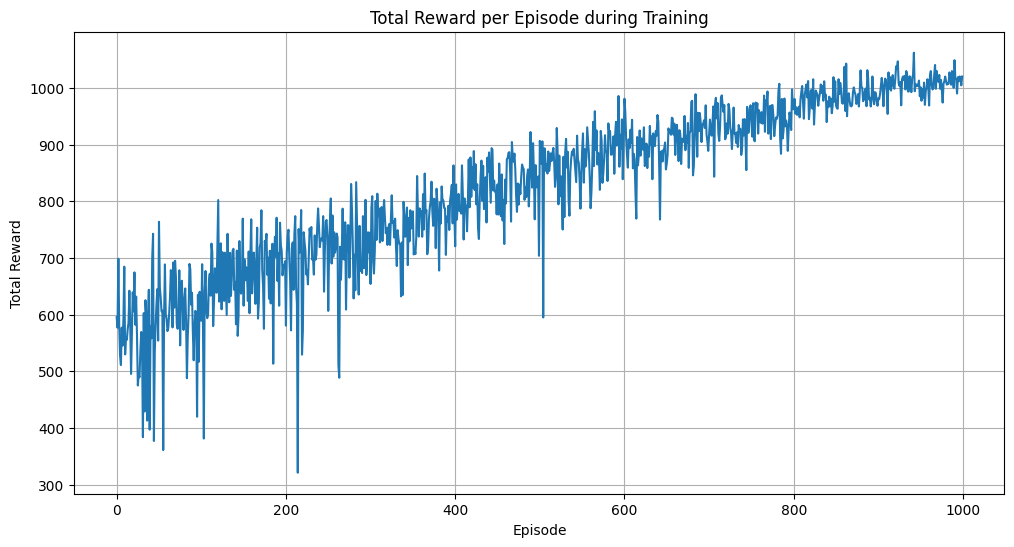

In [94]:
import matplotlib.pyplot as plt

# Plot the total rewards per episode
plt.figure(figsize=(12, 6))
plt.plot(total_rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode during Training')
plt.grid(True)
plt.show()